In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr

In [2]:
PATH_USER = Path('Z:/nahaUsers/casadje')
PATH_EFAS6 = PATH_USER / 'EFASv6'
file_name = 'lakes_efas6'

## Excel

In [20]:
path_lakes = PATH_EFAS6 / 'lakes' / 'tables'
old = pd.read_excel(path_lakes / 'efas6_lakes_20250218.xlsx')
new = pd.read_excel(path_lakes / 'efas6_lakes_20250828.xlsx')

print('{0} more lakes in the older version'.format(len(old) - len(new)))

0 more lakes in the older version


In [22]:
path_reservoirs = PATH_EFAS6 / 'reservoirs' / 'tables'
reservoirs = pd.read_excel(path_reservoirs / 'efas6_reservoirs_20250303+parameters.xlsx')

reservoirs.shape

(1359, 30)

In [23]:
# check lakes from EFAS 5 missing
set(old.loc[old.LakID.notnull(), 'LakID']).difference(new.LAK_ID)

set()

In [25]:
# check reservoirs from EFAS 5 missing
res_ids = set(old.loc[old.ResID.notnull(), 'ResID']).difference(new.RES_ID)
print(f'{len(res_ids)} reservoirs are missing')

2 reservoirs are missing


¿Están en la tabla de embalses?

In [26]:
res_ids.difference(reservoirs.RES_ID)

{126.0}

Eliminé ResID 126, así que hasta aquí todo bien.

In [27]:
# check lakes from GLWD_ID
set(old.loc[old.GLWD_ID.notnull(), 'GLWD_ID']).difference(new.GLWD_ID)

set()

In [28]:
# check lakes from HYLAK_ID
hylak_ids = set(old.loc[old.Hylak_id.notnull(), 'Hylak_id']).difference(new.HYLAK_ID)
print(f'{len(hylak_ids)} reservoirs are missing')

0 reservoirs are missing


¿Están en la tabla de embalses?

In [9]:
hylak_ids.difference(reservoirs.HYLAK_ID)

set()

Todo bien hasta aquí.

## Tables

In [29]:
dates = [
    '20250218',
    '20250828'
]

variables = [
    'alpha',
    'area',
    'avg_inflow',
]

tables = {}
for var in variables:
    print(var)
    df = []
    for date in dates:
        data = pd.read_csv(
            PATH_EFAS6 / 'tables' / f'{file_name}_{var}_{date}.txt',
            sep='\t',
            index_col=0, 
            header=None
        ).squeeze()
        data.index.name = 'GDW_ID'
        data.name = date
        print(f'\t{date}:\t{len(data)}')
        df.append(data)
    tables[var] = pd.concat(df, axis=1)

alpha
	20250218:	428
	20250828:	428
area
	20250218:	428
	20250828:	428
avg_inflow
	20250218:	428
	20250828:	428


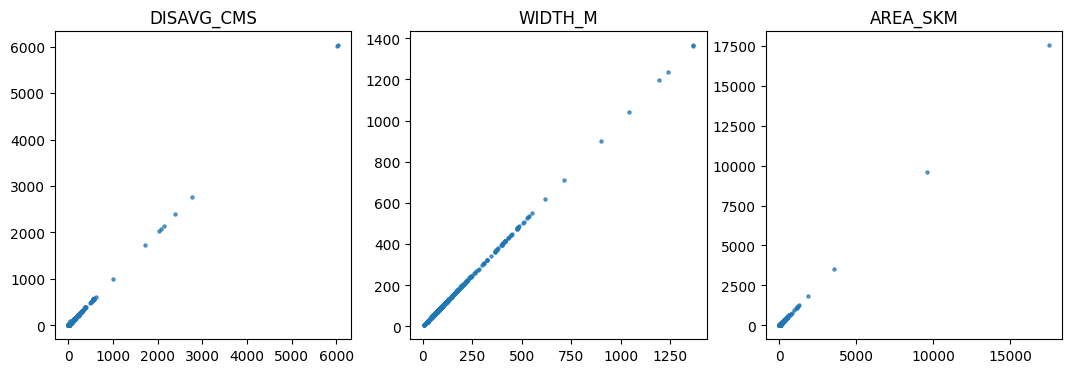

In [58]:
hylak_ids = list(set(old.Hylak_id).intersection(new.HYLAK_ID))

fig, axes = plt.subplots(ncols=3, figsize=(13, 4))

for ax, var in zip(axes, ['DISAVG_CMS', 'WIDTH_M', 'AREA_SKM']):
    ax.scatter(
        old.loc[old.Hylak_id.isin(hylak_ids)].sort_values('Hylak_id')[var],
        new.loc[new.HYLAK_ID.isin(hylak_ids)].sort_values('HYLAK_ID')[var],
        s=5,
        alpha=.7
    )
    ax.set(
        title=var
    )

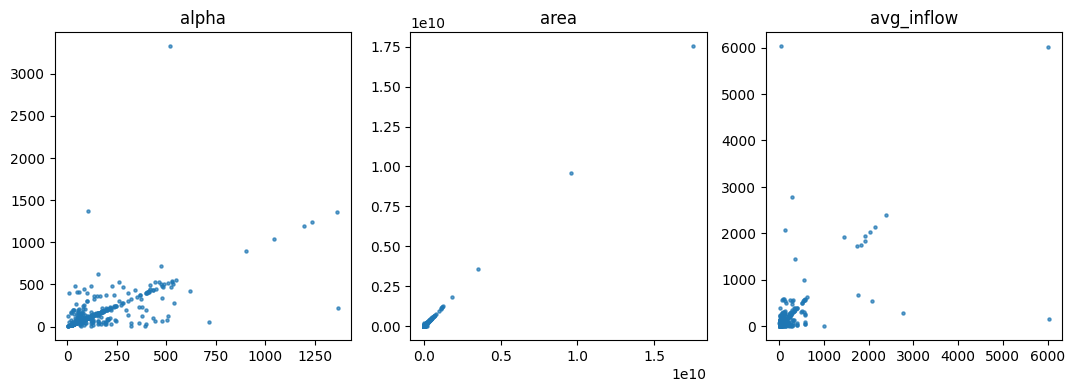

In [36]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4))

for ax, var in zip(axes, variables):
    ax.scatter(
        tables[var][dates[0]],
        tables[var][dates[1]],
        s=5,
        alpha=.7
    )
    ax.set(
        title=var
    )

## Map

In [37]:
def read_map(file: Path) -> xr.DataArray:
    data = rxr.open_rasterio(file).squeeze()
    data.close()
    data = data.where(data != 0, np.nan)
    return data

In [38]:
map_name = 'lakes_efas6_01min'

In [39]:
lakes_new = read_map(PATH_EFAS6 / 'static_maps' / f'{map_name}_20250828.nc')

ids_new = [int(x) for x in np.unique(lakes_new) if ~np.isnan(x)]
print(len(ids_new))

# lakes_new

428


In [40]:
lakes_old = read_map(PATH_EFAS6 / 'static_maps' / f'{map_name}_20250828.nc')

ids_old = [int(x) for x in np.unique(lakes_old) if ~np.isnan(x)]
print(len(ids_old))

428
